# COGS 108 - Final Project 

# Overview

Customer reviews are very important to the shopping experience in online retail. Shoppers on Amazon, EBay, Yelp,
and other major online retailers rely on customer reviews heavily before buying a product. For our project, we wanted to focus on reviews from Amazon.com and analyze them to figure out how, for a product, language used in the review and the overall rating given relate to each other. 

# Names

- Susmitha Kalidindi 
- Alyssa Ashmore 
- Shardul Saiya 
- Siyi Wang


# Research Question

We would like to study the correlation is between words used in product reviews with the ratings given for that
product by mapping the keywords in Amazon review text against the review ratings to see if words can be used to predict ratings. 

# Hypothesis

When we give positive reviews we tend to say “Very good product” or “Strongly Recommended” and the reviews will tend to have higher ratings. On the other hand, certain words like “Broken” or “Slow” will tend to have correlation with lower ratings for the review. We expect to see similar correspondence in our data, and we would like to explore the relation between emotions and language in a very simple way. 

# Introduction and Background

Online retailers such as Amazon have been littered with fake reviews recently, and this problem appears to be only getting worse with time. ReviewMeta, a website that analyzes millions of reviews and deletes suspicious reviews from their analysis, explains in their article (Reference 1) that there is a growing problem of “fake” reviews. For instance, ReviewMeta states that in the first three months of 2019, there are 42% of “Verified Purchases” and 58% of “Unverified Purchases,” compared to 2018, where there were 91% verified purchases and 9% unverified purchases. On top of that, these unverified purchases are often overwhelmingly positive compared to verified purchases, which could indicate reviews that are fake or paid for by companies trying to falsely promote their product. 

That being said, more analysis about the extent of this problem is necessary in order to provide more accurate product reviews for users. Where our data solution comes in when tackling this issue is analyzing the correlation between a reviewer’s word usage and their specific rating. We would like to then inquire about the relationship between fake or incentivized reviews and the reviewer’s word usage and specific ratings. Finally, we can use these findings to better discover suspicious or incentivized reviews and provide more accurate reviews to consumers.

Similar studies that have tackled this issue were done by researchers Mohan Kamal Hassan, Sana Prasanth Shakthi and R Sasikala in the paper “Sentimental analysis of Amazon reviews using naïve bayes on laptop products with MongoDB and R” (Reference 2). In this paper, they presented “an empirical study of efficacy of classifying product review by tagging the keyword . . . [and using] product users review comments about product and review about retailers from Amazon as data set and classify review text by subjectivity/objectivity and negative/positive attitude of buyer.” 

Additionally, students at Stanford University analyzed “the correlation between the Amazon product reviews and the rating of the products given by the customers” in their project using various techniques to find the most accurate one. They found that LSTM networks provided the most accurate correlation. 

References:
(1) "Amazon Flooded with Millions of Fake Reviews in 2019." ReviewMeta.
https://reviewmeta.com/blog/amazon-flooded-with-millions-of-fake-reviews-in-2019/

(2) "Sentimental analysis of Amazon reviews using naïve bayes on laptop products with MongoDB and R." Mohan Kamal Hassan et al 2017 IOP Conf. Ser.: Mater. Sci. Eng. 263 042090. 
https://www.researchgate.net/publication/321479545_Sentimental_analysis_of_Amazon_reviews_using_naive_bayes_on_laptop_products_with_MongoDB_and_R

# Dataset

Dataset Name: Consumer Reviews of Amazon Products

Link to the dataset: https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products#Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv

Number of observations: 34,000 reviews

This dataset contains a list of over 34,000 reviews of Amazon products like the Kindle, Fire TV, including measures on the basic product information, rating, review text, and more for each product.

# Part 1 - Review prediction without NLP

The first step that we took in our project was to explore and visualize the raw text reviews and ratings to get a better understanding and sense of the data.

# Setup

In [1]:
## Import Data from CSV file here, SEE Project proposal for link to csv file
import pandas as pd 

dfraw = pd.read_csv("../consumer-reviews-of-amazon-products/1429_1.csv", engine = 'python')

In [2]:
# used for cleaning data and tokenizing it and removing stop words
import nltk 
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

# nltk.download()
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to /Users/ssaiya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ssaiya/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Exploratory Raw Data Visualization

Text(0.5, 1.0, 'Categories')

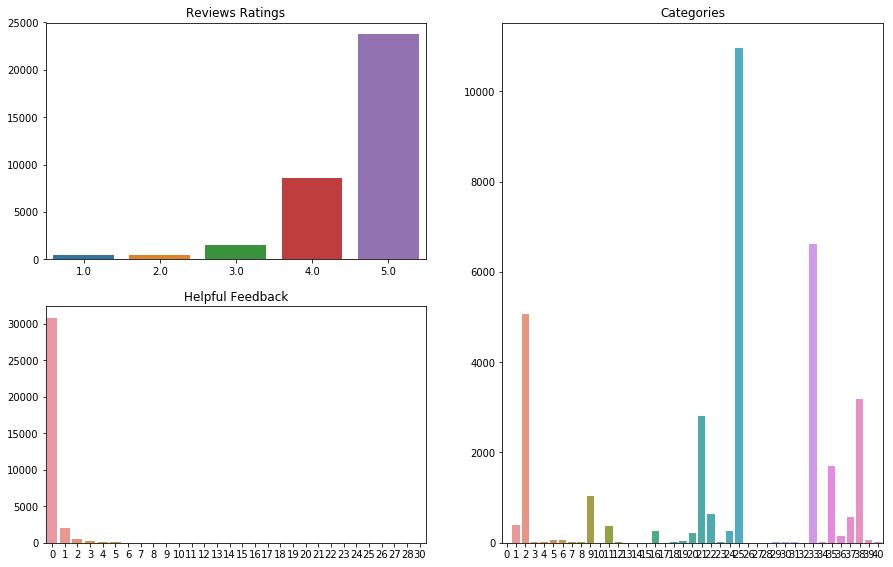

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,20))
ax1 = plt.subplot2grid((4, 2), (0, 0))
ax2 = plt.subplot2grid((4, 2), (1, 0))
ax3 = plt.subplot2grid((4, 2), (0, 1), rowspan=2)

rating_hist = dfraw.groupby('reviews.rating', as_index = False).count()
sns.barplot(x = rating_hist['reviews.rating'].values, y = rating_hist['id'].values, ax = ax1)

helpful_hist = dfraw.groupby('reviews.numHelpful', as_index = False).count()[0:30]
sns.barplot(x = helpful_hist['reviews.numHelpful'].values.astype(int), y = helpful_hist['id'].values, ax = ax2)

category_hist = dfraw.groupby('categories', as_index = False).count()
sns.barplot(x  =category_hist['categories'].index, y = category_hist['id'].values)

ax1.set_title("Reviews Ratings", fontsize = 12)
ax2.set_title("Helpful Feedback", fontsize = 12)
ax3.set_title("Categories", fontsize = 12)

#plt.gcf()

# Data Cleaning

During data cleaning, we got rid of the useless rows for our dataset. Then, we replaced hard to read characters in the review text with spaces to make our data analysis more efficient and easier.

In [4]:
# Get rid of most unwanted rows, only keep 
# Name, Category, Reviews.DoRecommend, Review.numHelpful, Reviews.ratings, Review.text, Review.title 

df1 = dfraw.drop(['asins', 'brand', 'keys', 'manufacturer', 'reviews.sourceURLs', 'reviews.userCity', 
                  'reviews.userProvince', 'reviews.username', 'reviews.dateAdded', 'reviews.dateSeen', 
                  'reviews.didPurchase' , 'reviews.id', 'id', 'reviews.date', 'reviews.numHelpful',
                  'name', 'categories', 'reviews.doRecommend'], axis=1)

#get rid of rewiews without ratings
df1_reviews = df1.dropna(subset=['reviews.rating', 'reviews.text', 'reviews.text'])

# Now df1 contains:
# reviews.doRecommend,
# reviews.rating, reviews.text, reviews.title

In [5]:
# Helper function to filter data
# Unused in final project, found better ways to filter data than this  ...
def filter_review(review):
    # Convert to string
    string = str(review)
    
    # Data Filtering
    string = string.replace('.', ' ')
    string = string.replace(',', ' ')
    string = string.replace('-', ' ')
    # string = string.replace('\'', ' ')
    string = string.replace('\"', ' ')
    string = string.replace('/', ' ')
    string = string.replace('(', ' ')
    string = string.replace(')', ' ')
    string = string.replace('!', ' ')
    string = string.replace('?', ' ')
    string = string.replace('=', ' ')
    string = string.replace('+', ' ')
    string = string.replace('-', ' ')
    string = string.replace('�', '')
    string = string.replace('☺️', ' ')
    string = string.replace('&', ' ')
    string = string.replace('$', ' ')
    string = string.replace('*', ' ')
    string = string.replace('%', ' ')

    return string

### What our data currently looks like

In [6]:
df1_reviews.head()

reviews.rating                                       reviews.text  \
0             5.0  This product so far has not disappointed. My c...   
1             5.0  great for beginner or experienced person. Boug...   
2             5.0  Inexpensive tablet for him to use and learn on...   
3             4.0  I've had my Fire HD 8 two weeks now and I love...   
4             5.0  I bought this for my grand daughter when she c...   

                             reviews.title  
0                                   Kindle  
1                                very fast  
2  Beginner tablet for our 9 year old son.  
3                                  Good!!!  
4                Fantastic Tablet for kids

# Data cleaning Using NLTK
### clean_text Does the following things:
- lower case the text
- tokenize the text 
- remove punctuation
- remove useless words that contain numbers
- remove useless stop words like ‘the’, ‘a’ ,’this’ etc.
- Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
- lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)

In [7]:
# Helper functions to clean data
# Used twice, once with nlp, once wihtout nlp.
def clean_text(text):
    
    # float/int etc to string
    text = str(text)
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [8]:
df1_reviews["review_clean"] = df1_reviews["reviews.text"].apply(lambda x: clean_text(x))
df1_reviews.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


reviews.rating                                       reviews.text  \
0             5.0  This product so far has not disappointed. My c...   
1             5.0  great for beginner or experienced person. Boug...   
2             5.0  Inexpensive tablet for him to use and learn on...   
3             4.0  I've had my Fire HD 8 two weeks now and I love...   
4             5.0  I bought this for my grand daughter when she c...   

                             reviews.title  \
0                                   Kindle   
1                                very fast   
2  Beginner tablet for our 9 year old son.   
3                                  Good!!!   
4                Fantastic Tablet for kids   

                                        review_clean  
0  product far disappointed child love use like a...  
1     great beginner experience person buy gift love  
2  inexpensive tablet use learn step nabi thrill ...  
3  i've fire hd two week love tablet great value....  
4  buy grand daughter come visit set user enter a...

In [9]:
# dictionary to count all unique words in customer reviews
# contains word : frequency
words_dict = {}

# Helper function to count words in a string 
# This function directly modifies the words_dict declared above
def word_frequency_counter(review):
    
    string = filter_review(review)

    # Convert to lower case and split
    my_string = string.lower().split()
    for item in my_string:
        if item in words_dict:
            words_dict[item] += 1
        else:
            words_dict[item] = 1

In [10]:
# Dictionary to count raw rating value of each word
rating_dict = {}

# Helper function to add up raw review values for each word and 
def rating_counter(review, rating):
    string = filter_review(review)
    rating = int(rating)
    
    # Convert to lower case and split
    my_string = string.lower().split()
    for item in my_string:
        if item in rating_dict:
            rating_dict[item] = rating_dict[item] + rating
        else:
            rating_dict[item] = rating
    

In [11]:
# Now we have two dictionaries
# word_dict contains words associated with their frequency in all the ratings
# rating_dict_raw cotains words associated with their raw rating values, summed up

# Now we want to divide the values in rating_dict by the frequency values in word_dict
# Thats what this helper function does, and saves it in rating_dict
def ratings_avg(word_dict, rating_dict):
    for item in word_dict:
        if item in rating_dict:
            rating_dict[item] = rating_dict[item]/word_dict[item]
        else:
            print('This shouldnt happen !!')


In [12]:
for review in df1_reviews['review_clean']:
    word_frequency_counter(review)
for index, row in df1_reviews.iterrows():
    rating_counter(row['review_clean'], row['reviews.rating'])

ratings_avg(words_dict, rating_dict)

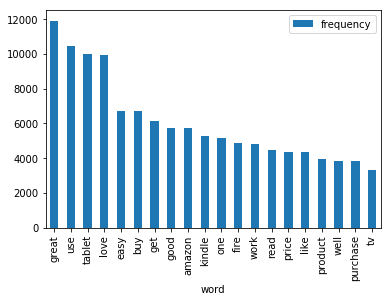

In [13]:
# Visualize word frequency's for top words with a histogram or some other graph
sorted_words_list = list(sorted(words_dict.items(), key=lambda item: item[1], reverse=True))
words_list_20 = sorted_words_list[0:20] 
df_words = pd.DataFrame(words_list_20, columns=['word', 'frequency'])
df_words.plot(kind='bar', x='word')

We noticed a lot of neutral words in this graph, 

such as Get, One, etc


These are not as helpfull for sentiment analysis, so our next approach is to try to remove them

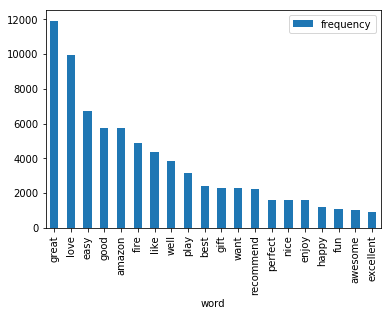

In [14]:
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import copy

sid = SentimentIntensityAnalyzer()
sorted_words_list = list(sorted(words_dict.items(), key=lambda item: item[1], reverse=True))
sorted_words_list_nonneutral = copy.deepcopy(sorted_words_list)

for item in sorted_words_list:
    ss = sid.polarity_scores(item[0])
    # if word is neutral, then don't include it in this graph
    # we only care about positive/negative words
    if ss['neu'] == 1.0:
        sorted_words_list_nonneutral.remove(item)


words_list_20_nonneutral = sorted_words_list_nonneutral[0:20] 
df_words_nonneutral = pd.DataFrame(words_list_20_nonneutral, columns=['word', 'frequency'])
df_words_nonneutral.plot(kind='bar', x='word')

In [15]:
predicted_list = []
def review_predictor( review):
    sum = 1
    freq = 1
    for word in review.split():
        if word in rating_dict:
            freq = freq + 1
            sum = sum + rating_dict[word]
            
    predicted_rating = sum / freq
    predicted_list.append(predicted_rating)
    

In [16]:
for review in df1_reviews['review_clean']:
    review_predictor(review)
df1_reviews['predicted'] = predicted_list

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
df1_reviews.head()

reviews.rating                                       reviews.text  \
0             5.0  This product so far has not disappointed. My c...   
1             5.0  great for beginner or experienced person. Boug...   
2             5.0  Inexpensive tablet for him to use and learn on...   
3             4.0  I've had my Fire HD 8 two weeks now and I love...   
4             5.0  I bought this for my grand daughter when she c...   

                             reviews.title  \
0                                   Kindle   
1                                very fast   
2  Beginner tablet for our 9 year old son.   
3                                  Good!!!   
4                Fantastic Tablet for kids   

                                        review_clean  predicted  
0  product far disappointed child love use like a...   4.228766  
1     great beginner experience person buy gift love   4.122082  
2  inexpensive tablet use learn step nabi thrill ...   4.205570  
3  i've fire hd two week love tablet great value....   4.428850  
4  buy grand daughter come visit set user enter a...   4.440112

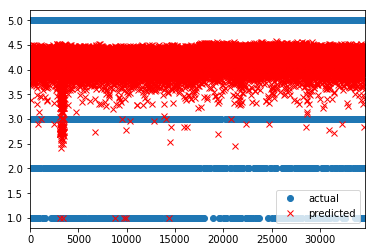

In [18]:
df1_reviews_sample = df1_reviews.sample(frac = 0.01, replace = False, random_state=42)

d = {'actual' : df1_reviews['reviews.rating'],
     'predicted' : df1_reviews['predicted']}

df = pd.DataFrame(d)

df.plot(style=['o','rx'])

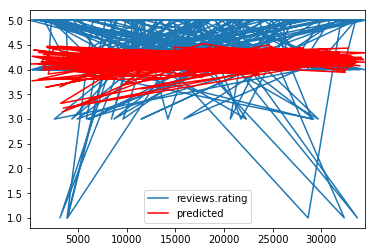

In [19]:
# gca stands for 'get current axis'
ax = plt.gca()
df1_reviews_sample.plot(kind='line',y='reviews.rating',ax=ax)
df1_reviews_sample.plot(kind='line',y='predicted', color='red', ax=ax)

plt.show()

## Why is the data so skewed ?
 - Since the data had a very positive skew to begin with, this was expected. 
 - About 6 percent of our reviews are considered negative ones. which is why our predictions arent accurate.
 - To solve this problem , we have to not only give words their raw frequency values, but also account for the importance of them and be able to account for negatives or double negatoves.

# Problem with the Above Approach 
The naive way of simply counting how many times each word appears in every document is that it doesn’t take into account the relative importance of words in the texts. 
A word that appears in almost every text would not likely bring useful information for analysis. For example, words like "the", "and", "in" may be extremely common words used in reviews but they don't provide any insight into understanding the polarity of reviews.
On the contrary, rare words may have a lot more of meanings.

# Hence the motivation for Part 2...

### We add the TF-IDF (Term Frequency — Inverse Document Frequency) values for every word and every document.
The TF-IDF metric solves this problem:

- TF computes the classic number of times the word appears in the text
- IDF computes the relative importance of this word which depends on how many texts the word can be found

# PART 2
## Detecting Bad customer reviews with NLP

For each textual review, we want to predict if it corresponds to a good review (the customer is happy) or to a bad one (the customer is not satisfied). The reviews overall ratings can range from 0/5 to 5/5. 

We will split those into two categories:

bad reviews have overall ratings < 2.5
good reviews have overall ratings >= 2.5

Then we see if we are be able to predict this information using only the raw textual data from the review. Let’s get it started!

In [20]:
df2 = dfraw.drop(['asins', 'brand', 'keys', 'manufacturer', 'reviews.sourceURLs', 'reviews.userCity', 
                  'reviews.userProvince', 'reviews.username', 'reviews.dateAdded', 'reviews.dateSeen', 
                  'reviews.didPurchase' , 'reviews.id', 'id' ], axis=1)
reviews_df = df2.drop(['name','reviews.date', 'categories'], axis=1)

# create the label
reviews_df["is_bad_review"] = reviews_df["reviews.rating"].apply(lambda x: 1 if x <= 3 else 0)
# select only relevant columns
reviews_df = reviews_df[["reviews.text", "is_bad_review"]]


In [21]:
# This is what our data now looks like
reviews_df.head()

reviews.text  is_bad_review
0  This product so far has not disappointed. My c...              0
1  great for beginner or experienced person. Boug...              0
2  Inexpensive tablet for him to use and learn on...              0
3  I've had my Fire HD 8 two weeks now and I love...              0
4  I bought this for my grand daughter when she c...              0

In [22]:
# Sample the data to speed up computation,
# uncomment is data is taking too long but shouldnt be necessary
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)


In [23]:
reviews_df["review_clean"] = reviews_df["reviews.text"].apply(lambda x: clean_text(x))
reviews_df.head()

reviews.text  is_bad_review  \
1763   I received this as a gift after my original Ki...              0   
20879  Bought this for easier reading and it meets my...              0   
26427  Alexa does all that was described. It is like ...              0   
8344   I researched about tablets and based on my int...              0   
34279  This is not our first Amazon Fire---we have th...              0   

                                            review_clean  
1763   receive gift original kindle fire start give t...  
20879  buy easy read meet expectation great display f...  
26427  alexa describe like assistant selects music ma...  
8344   research tablet base interest choose amazon fi...  
34279  first amazon fire---we every tv house cord cut...

# Sentiment Analysis
We use Vader, which is a part of the NLTK module designed for sentiment analysis. 
Vader uses a lexicon of words to find which ones are positives or negatives. 
It also takes into account the context of the sentences to determine the sentiment scores. 
For each text, Vader returns 4 values:
- Negativity score (neg)
- Neutrality score (neu)
- Positivity score (pos)
- Overall score (compound)


In [24]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["reviews.text"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)


Next, we find simple metrics for every text which we will use ahead :
- Number of characters in each review
- Number of words in each review

In [25]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["reviews.text"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["reviews.text"].apply(lambda x: len(x.split(" ")))

In [26]:
reviews_df.head()

reviews.text  is_bad_review  \
1763   I received this as a gift after my original Ki...              0   
20879  Bought this for easier reading and it meets my...              0   
26427  Alexa does all that was described. It is like ...              0   
8344   I researched about tablets and based on my int...              0   
34279  This is not our first Amazon Fire---we have th...              0   

                                            review_clean    neg    neu    pos  \
1763   receive gift original kindle fire start give t...  0.093  0.645  0.262   
20879  buy easy read meet expectation great display f...  0.000  0.615  0.385   
26427  alexa describe like assistant selects music ma...  0.000  0.844  0.156   
8344   research tablet base interest choose amazon fi...  0.104  0.736  0.160   
34279  first amazon fire---we every tv house cord cut...  0.049  0.815  0.135   

       compound  nb_chars  nb_words  
1763     0.9498       474        89  
20879    0.7845        84        13  
26427    0.5848       161        30  
8344     0.0772       136        24  
34279    0.8055       317        57

The next step consist in extracting vector representations for every review. 
The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). 
This is performed using shallow neural networks. What’s interesting is that similar words will have similar representation vectors

In [27]:
# create doc2vec vector columns
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.

We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

# Exploratory Data Analysis

In [29]:
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.937969
1    0.062031
Name: is_bad_review, dtype: float64

So as you may have noticed, about 6 percent of our reviews are considered negative ones.

# WordCloud of data after filtering and cleaning

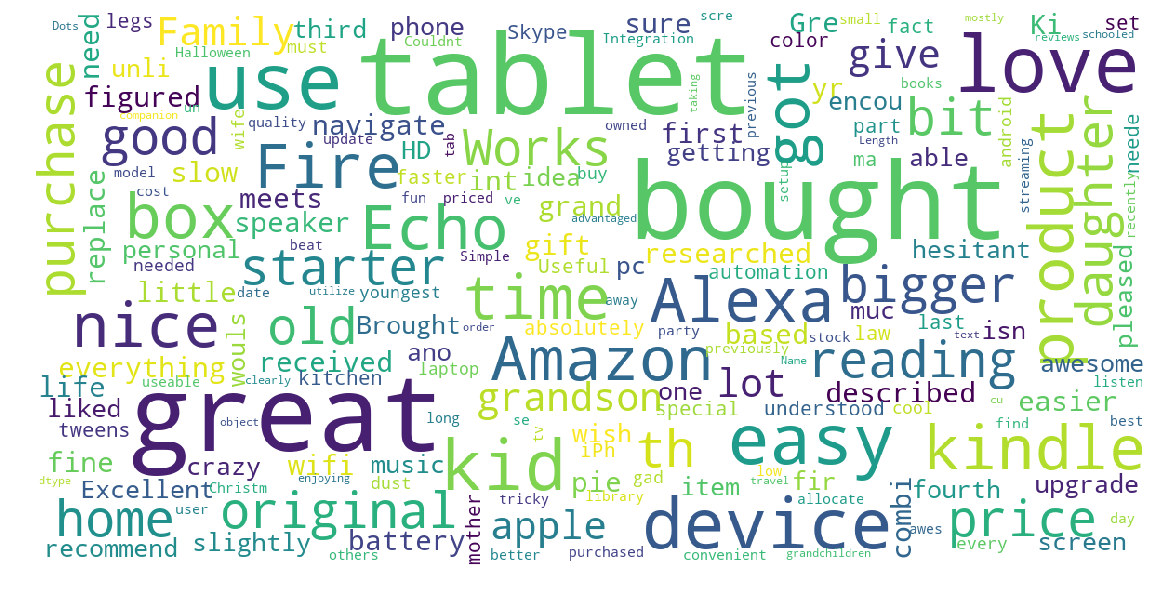

In [30]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["reviews.text"])

# Most Positive reviews

In [31]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["reviews.text", "pos"]].head(10)

reviews.text    pos
11909  Great great great great great great great grea...  0.970
13701  Excellent Product & Highly recommended. Excell...  0.830
11551  Awesome tablet. Performance great. Perfect buy...  0.813
34060  I love it, pretty fast!!! Good resolution, nic...  0.777
20572  I love it. Will definitely recommend it to a f...  0.759
10779  Great battery life and easy to navigate!!! Gre...  0.746
8387   Great Device! Quick, easy to use and a great v...  0.738
4471   easy to use. looks good. The prize winner was ...  0.728
32343  Easy to install and use. Easy set-up. Great fo...  0.719
32908  good product for a best price! highly recommen...  0.716

# Most Negative reviews

In [32]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["reviews.text", "neg"]].head(10)

reviews.text    neg
6633   Bad graphics. Ugly design. Good for the price....  0.485
33755  Not user friendly. Sluggish, confusing, and ex...  0.455
10241  So far no problems except no kid friendly case...  0.437
30397  My old fire stick had just died. So I upgraded...  0.431
32521  I was tired of the insane cable bills, so I bo...  0.421
9489   Perfect size reader, no fuss, websurfing, vide...  0.399
29017  hard to use, and does not support Guam. online...  0.394
3852   No bad for the price. The bad is the got too m...  0.365
19402  No glare anywhere--even on the beach! Also you...  0.362
8612   Good phone but my return visit the customer se...  0.358

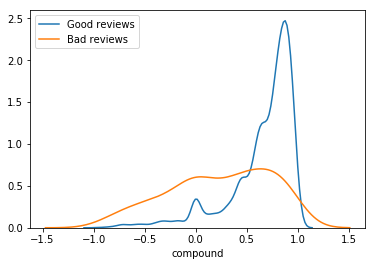

In [33]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

# Data Analysis & Results

# Predicting is_bad_review


We first choose which features we want to use to train our model

In [34]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "reviews.text", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

Split our data into two parts:
- one to train our model
- one to test its performances

In [35]:
# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], 
                                        reviews_df[label], test_size = 0.20, random_state = 42)

Now we will train the random forest classifier

In [36]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

# Most Important Features 

In [37]:
# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

feature  importance
3            compound    0.038026
2                 pos    0.035867
1                 neu    0.025289
4            nb_chars    0.018987
542       word_return    0.017968
8    doc2vec_vector_2    0.017689
9    doc2vec_vector_3    0.017324
0                 neg    0.016941
6    doc2vec_vector_0    0.016396
5            nb_words    0.015952
10   doc2vec_vector_4    0.015863
7    doc2vec_vector_1    0.015249
588         word_slow    0.012335
437           word_ok    0.010915
53          word_apps    0.010555
365         word_like    0.008604
276         word_good    0.007985
268          word_get    0.007562
634       word_tablet    0.007100
667          word_try    0.007005

- The most important features are indeed the ones that come from the previous sentiment analysis.
ie - compound, pos, neu.

- The vector representations of the texts also have a lot of importance in our training. 
- Some words appear to have a fairly good importance as well.


# Scatterplot to show classifier

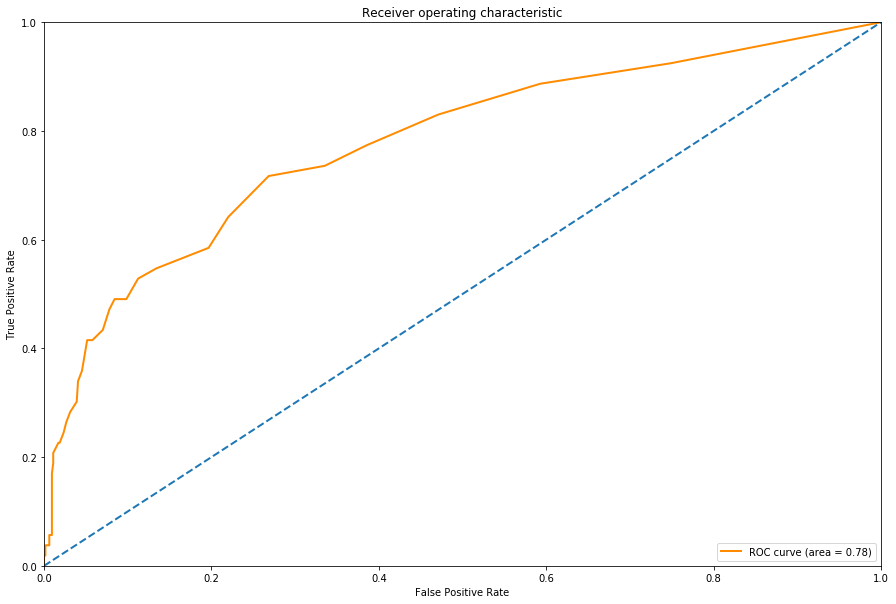

In [38]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Privacy/Ethics Considerations

To better understand what our ethical and privacy concerns may be in answering this data science question, we looked into Amazon’s privacy policy on using user review data for data analysis. One section of Amazon’s Privacy notice states that “Information You Give Us: We receive and store any information you enter on our Web site or give us in any other way. You can choose not to provide certain information, but then you might not be able to take advantage of many of our features. We use the information that you provide for such purposes as responding to your requests, customizing future shopping for you, improving our stores, and communicating with you.” 

Thus, as part of amazon’s policy, users agree for some parts of their data to be public information to take advantage of features like customer reviews and personalized shopping. For our data science project, we are only using their reviews and ratings of which they have already voluntarily partook in. Hence, we don’t have any privacy concerns by using our dataset. Additionally, Amazon provides the customer reviews dataset on AWS.

Additionally, we also don’t have any ethical concerns as Amazon’s data is already filtered to remove offensive terms and phrases.

# Conclusion & Discussion

To reiterate our goal for this project, 

_We would like to study the correlation is between words used in product reviews with the ratings given for that product by mapping the keywords in Amazon review text against the review ratings to see if words can be used to predict ratings._

We found that it is _definitely_ possible to only use words to predict sentiment, as long as the right features are extracted from the raw source data, and the source data is not extremely skewed.

We also noticed how rarity of words have a strong correlation with the sentiment prediction,
ie: Rarer words are stronger predictors than common words, 
This was proven by a much better prediction model in our second approach when we accounted for TFIDF.

One limitation of this project is that it only includes consumer reviews of Amazon products only, such as Kindle, Kindle Fire, etc, so we are not analyzing an incredible variety of products. It's likely that the polarity of the reviews is slightly skewed because of this; as we saw from the data, only 6% of the reviews were negative. Also as mentioned earlier in the introduction, we can expect there to be some level of fake reviews for these products that affects the dataset. It would take additional data sanitization to remove these fake reviews to ensure higher quality data; however we were not able to do this given the time constraints.

Another limitation was the fact that our data was very limited and was very positiviely skewed which affected our analysis in the first place.

We wanted to see how language and emotions related to each other by analyzing reviews. This project is impactful since we learned that commonly used words don't offer indication to any specific emotion since these tend to be idiosyncratic words like "the", "in", "of." It's better to analyze infrequent words, such as "broken" or "failed" in a review since they might offer more of a insight into a specific sentiment. 
When analysing which features were strongest predictors for the review rating, we found that
- The most important features are the ones that come from the sentiment analysis. ie - compound, pos, neu.
- The vector representations of the texts also have a lot of importance in our training.
- Some words appear to have a fairly good importance as well.

